<a href="https://colab.research.google.com/github/soom1nb/Introduction-to-Computer-Vision/blob/main/assignment_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Introduction to Computer Vision]**
## K-Nearest Neighbors on CIFAR-10  
### Student: Baik Soo Min  
### Student ID: 2022112338  
### Major: Data Science  

# **0. Import**

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# **1. CIFAR-10 download & preprocessing**
- Images are flattened from (32,32,3) -> (3072,)
- Xtr, Ytr : train features and labels
- Xte, Yte : test features and labels
- Standardization

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#flatten
Xtr = torch.tensor(train_dataset.data.reshape(50000, -1) / 255.0, dtype=torch.float32).to(device)
Ytr = torch.tensor(train_dataset.targets, dtype=torch.long).to(device)
Xte = torch.tensor(test_dataset.data.reshape(10000, -1) / 255.0, dtype=torch.float32).to(device)
Yte = torch.tensor(test_dataset.targets, dtype=torch.long).to(device)

#standardization
mean = Xtr.mean(dim=0, keepdim=True)
std = Xtr.std(dim=0, keepdim=True) + 1e-8
Xtr = (Xtr - mean) / std
Xte = (Xte - mean) / std

Using device: cuda


100%|██████████| 170M/170M [00:04<00:00, 40.2MB/s]


# **2. Vectorized Nearest Neighbor Classifier**
- Vectorization for computing more fast
- train method:
  - Store training data and labels
- predict method:
  - Compute L1 distance


In [4]:
class KNN:
    def __init__(self):
        pass

    def train(self, X, y):
        self.Xtr = X
        self.Ytr = y

    def predict(self, X, k=1, batch_size=500):
        preds = []
        with torch.no_grad():
            for i in tqdm(range(0, X.shape[0], batch_size), desc=f"KNN Predict (k={k})"):
                X_batch = X[i:i+batch_size]
                dists = torch.cdist(X_batch, self.Xtr, p=1)  # L1 distance
                _, idx = torch.topk(dists, k, largest=False)
                neighbors = self.Ytr[idx]
                preds_batch = torch.mode(neighbors, dim=1).values
                preds.append(preds_batch)
                del dists, idx, neighbors
                torch.cuda.empty_cache()
        return torch.cat(preds, dim=0)

# **3. Train/Test Split only**
- Predict labels on the test data using a chosen k = 1
- Metrics : accuracy, precision, recall, F1-score

In [5]:
nn = KNN()
nn.train(Xtr, Ytr)
Yte_pred = nn.predict(Xte, k=1, batch_size=500)

print("\n=== Train/Test metrics (k=1) ===")
print("Accuracy:", accuracy_score(Yte.cpu(), Yte_pred.cpu()))
print("Precision:", precision_score(Yte.cpu(), Yte_pred.cpu(), average='macro'))
print("Recall:", recall_score(Yte.cpu(), Yte_pred.cpu(), average='macro'))
print("F1-score:", f1_score(Yte.cpu(), Yte_pred.cpu(), average='macro'))

KNN Predict (k=1): 100%|██████████| 20/20 [00:01<00:00, 14.72it/s]



=== Train/Test metrics (k=1) ===
Accuracy: 0.3889
Precision: 0.43612170248017534
Recall: 0.3889
F1-score: 0.3892319211237392


# **4. Validation split for hyperparameter tuning**
- Split the original train set into
  - Train subset : 49,000 samples
  - Validation set : 1,000 samples
- Use Validation set to select the best value of k based on accuracy

[Code result]
- best value of k : 10

In [6]:
Xval = Xtr[:1000]
Yval = Ytr[:1000]
Xtr_sub = Xtr[1000:]
Ytr_sub = Ytr[1000:]

k_values = [1, 3, 5, 10, 20]
validation_accuracies = []

for k in k_values:
    nn = KNN()
    nn.train(Xtr_sub, Ytr_sub)
    Yval_pred = nn.predict(Xval, k=k, batch_size=200)
    acc = accuracy_score(Yval.cpu(), Yval_pred.cpu())
    validation_accuracies.append((k, acc))
    print(f"Validation accuracy (k={k}): {acc:.4f}")

best_k = max(validation_accuracies, key=lambda x: x[1])[0]
print("Best k:", best_k)

# Test with best k
nn.train(Xtr_sub, Ytr_sub)
Yte_pred = nn.predict(Xte, k=best_k, batch_size=500)

print("\n=== Test metrics with best k ===")
print("Accuracy:", accuracy_score(Yte.cpu(), Yte_pred.cpu()))
print("Precision:", precision_score(Yte.cpu(), Yte_pred.cpu(), average='macro'))
print("Recall:", recall_score(Yte.cpu(), Yte_pred.cpu(), average='macro'))
print("F1-score:", f1_score(Yte.cpu(), Yte_pred.cpu(), average='macro'))

KNN Predict (k=1): 100%|██████████| 5/5 [00:00<00:00, 1930.01it/s]


Validation accuracy (k=1): 0.3760


KNN Predict (k=3): 100%|██████████| 5/5 [00:00<00:00,  9.17it/s]


Validation accuracy (k=3): 0.3620


KNN Predict (k=5): 100%|██████████| 5/5 [00:00<00:00, 2294.98it/s]


Validation accuracy (k=5): 0.3630


KNN Predict (k=10): 100%|██████████| 5/5 [00:00<00:00, 2271.37it/s]


Validation accuracy (k=10): 0.3820


KNN Predict (k=20): 100%|██████████| 5/5 [00:00<00:00, 1279.14it/s]


Validation accuracy (k=20): 0.3650
Best k: 10


KNN Predict (k=10): 100%|██████████| 20/20 [00:00<00:00, 3094.97it/s]


=== Test metrics with best k ===


Accuracy: 0.3856
Precision: 0.4663613792338016
Recall: 0.38560000000000005
F1-score: 0.38030244909201766


# **5. 5-Fold Cross-Validation**
- Split the dataset into 5 folds
- k_values = [1, 3, 5, 10, 20]
- besk value of k : 10


In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {k: [] for k in k_values}

for k in k_values:
    print(f"\nProcessing k={k} for 5-Fold CV")
    for fold, (train_idx, val_idx) in enumerate(kf.split(Xtr), 1):
        X_train, X_val = Xtr[train_idx], Xtr[val_idx]
        Y_train, Y_val = Ytr[train_idx], Ytr[val_idx]

        nn = KNN()
        nn.train(X_train, Y_train)
        Y_val_pred = nn.predict(X_val, k=k, batch_size=200)
        acc = accuracy_score(Y_val.cpu(), Y_val_pred.cpu())
        cv_results[k].append(acc)
        print(f"  Fold {fold}: Accuracy = {acc:.4f}")

cv_mean = [np.mean(cv_results[k]) for k in k_values]
cv_std = [np.std(cv_results[k]) for k in k_values]


Processing k=1 for 5-Fold CV


KNN Predict (k=1): 100%|██████████| 50/50 [00:00<00:00, 60.48it/s] 


  Fold 1: Accuracy = 0.3739


KNN Predict (k=1): 100%|██████████| 50/50 [00:00<00:00, 58.89it/s]


  Fold 2: Accuracy = 0.3739


KNN Predict (k=1): 100%|██████████| 50/50 [00:00<00:00, 58.35it/s]


  Fold 3: Accuracy = 0.3752


KNN Predict (k=1): 100%|██████████| 50/50 [00:00<00:00, 56.33it/s]


  Fold 4: Accuracy = 0.3716


KNN Predict (k=1): 100%|██████████| 50/50 [00:00<00:00, 53.82it/s]


  Fold 5: Accuracy = 0.3680

Processing k=3 for 5-Fold CV


KNN Predict (k=3): 100%|██████████| 50/50 [00:00<00:00, 53.81it/s]


  Fold 1: Accuracy = 0.3544


KNN Predict (k=3): 100%|██████████| 50/50 [00:00<00:00, 54.74it/s]


  Fold 2: Accuracy = 0.3588


KNN Predict (k=3): 100%|██████████| 50/50 [00:00<00:00, 54.94it/s]


  Fold 3: Accuracy = 0.3469


KNN Predict (k=3): 100%|██████████| 50/50 [00:00<00:00, 54.62it/s]


  Fold 4: Accuracy = 0.3571


KNN Predict (k=3): 100%|██████████| 50/50 [00:00<00:00, 53.83it/s]


  Fold 5: Accuracy = 0.3505

Processing k=5 for 5-Fold CV


KNN Predict (k=5): 100%|██████████| 50/50 [00:00<00:00, 53.90it/s]


  Fold 1: Accuracy = 0.3691


KNN Predict (k=5): 100%|██████████| 50/50 [00:00<00:00, 54.13it/s]


  Fold 2: Accuracy = 0.3749


KNN Predict (k=5): 100%|██████████| 50/50 [00:00<00:00, 54.02it/s]


  Fold 3: Accuracy = 0.3658


KNN Predict (k=5): 100%|██████████| 50/50 [00:00<00:00, 53.94it/s]


  Fold 4: Accuracy = 0.3699


KNN Predict (k=5): 100%|██████████| 50/50 [00:00<00:00, 54.40it/s]


  Fold 5: Accuracy = 0.3645

Processing k=10 for 5-Fold CV


KNN Predict (k=10): 100%|██████████| 50/50 [00:00<00:00, 55.08it/s]


  Fold 1: Accuracy = 0.3673


KNN Predict (k=10): 100%|██████████| 50/50 [00:00<00:00, 54.47it/s]


  Fold 2: Accuracy = 0.3817


KNN Predict (k=10): 100%|██████████| 50/50 [00:00<00:00, 54.82it/s]


  Fold 3: Accuracy = 0.3696


KNN Predict (k=10): 100%|██████████| 50/50 [00:00<00:00, 54.80it/s]


  Fold 4: Accuracy = 0.3709


KNN Predict (k=10): 100%|██████████| 50/50 [00:00<00:00, 54.35it/s]


  Fold 5: Accuracy = 0.3718

Processing k=20 for 5-Fold CV


KNN Predict (k=20): 100%|██████████| 50/50 [00:00<00:00, 54.35it/s]


  Fold 1: Accuracy = 0.3567


KNN Predict (k=20): 100%|██████████| 50/50 [00:00<00:00, 53.81it/s]


  Fold 2: Accuracy = 0.3675


KNN Predict (k=20): 100%|██████████| 50/50 [00:00<00:00, 54.00it/s]


  Fold 3: Accuracy = 0.3541


KNN Predict (k=20): 100%|██████████| 50/50 [00:00<00:00, 54.98it/s]


  Fold 4: Accuracy = 0.3641


KNN Predict (k=20): 100%|██████████| 50/50 [00:00<00:00, 54.85it/s]


  Fold 5: Accuracy = 0.3603


# **6. Plot Cross-Validation performance**
- Plot accuracy vs k with error bars

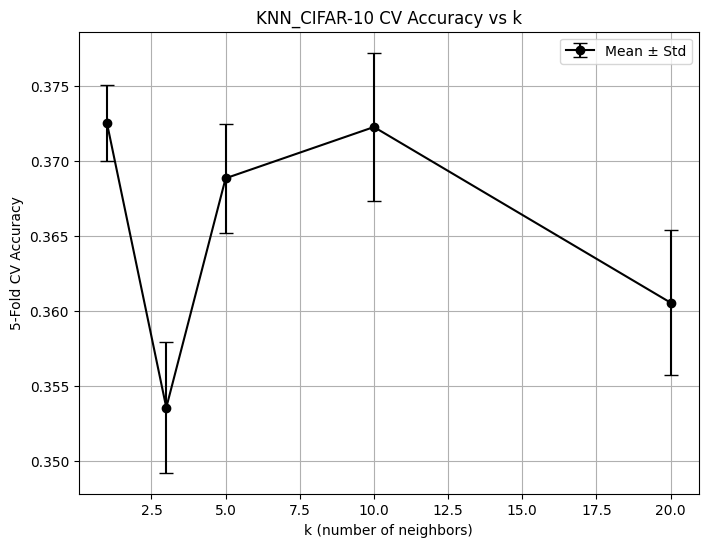

In [8]:
plt.figure(figsize=(8,6))
plt.errorbar(k_values, cv_mean, yerr=cv_std, fmt='-o', capsize=5, color='black', label='Mean ± Std')
plt.xlabel('k (number of neighbors)')
plt.ylabel('5-Fold CV Accuracy')
plt.title('KNN_CIFAR-10 CV Accuracy vs k')
plt.grid(True)
plt.legend()
plt.show()